## Import the libraries

Summary
#Author           : Rozita_Nazari
#Project Name     : DDiagnosis and diagnosis of kovid19 using images  Raio X 
#Description      :   
#Tools/Library    : Python, Keras, TensorFlow
#Version History  : 1.0.0.0
#Current Version  : 1.0.0.0
#Last Update      : 23.03.2020

Datasets
Dataset Name     : COVID-19 image data collection
Dataset Link     : COVID-19 image data collection (Original Dataset)
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : Chest X-Ray Images (Pneumonia) (Original Dataset)


In [149]:
# import the necessary packages
#%tensorflow_version 2.x
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
%matplotlib inline

In [150]:
# initialize directory 
dataset="DataSet/seg_train/"

dataset_dir = os.path.join(dataset)

model_name="covid19.model"

In [151]:
args={}
args["dataset"]=dataset

In [152]:
from IPython.display import Image, display
display(Image('NORMAL2-IM-0315-0001.jpeg',width=120))
print("Normal")


Normal


In [153]:
from IPython.display import Image, display
display(Image('Test0.jpg',width=120))
print("Kovid19")

Kovid19


In [154]:
train_covid_dir     = os.path.join(dataset_dir, 'covidct')  # directory with our training Covid pictures
train_normal_dir    = os.path.join(dataset_dir, 'normalct')  # directory with our training Normal pictures
train_Boronsit_dir    = os.path.join(dataset_dir, 'Boronsit')  # directory with our training Covid pictures
train_Penomoni_dir     = os.path.join(dataset_dir, 'Penomoni')  # directory with our training Covid pictures
train_Possible_Covid_dir     = os.path.join(dataset_dir, 'Possible Covid')  # directory with our training Covid pictures
train_possible_Penomoni_dir     = os.path.join(dataset_dir, 'possible Penomoni')  # directory with our training Covid pictures
#train_pneumonia_dir = os.path.join(dataset_dir, 'pneumonia')  # directory with our training pneumonia/other pictures

num_covid_dir     = len(os.listdir(train_covid_dir))
num_normal_dir    = len(os.listdir(train_normal_dir))
num_Boronsit_dir    = len(os.listdir(train_Boronsit_dir))
num_Penomoni_dir    = len(os.listdir(train_Penomoni_dir))
num_Possible_Covid_dir    = len(os.listdir(train_Possible_Covid_dir))
num_possible_Penomoni_dir    = len(os.listdir(train_possible_Penomoni_dir))
#num_pneumonia_dir = len(os.listdir(train_pneumonia_dir))

print('Total Train Covid-19  images:', num_covid_dir)
print('Total Train Normal    images:', num_normal_dir)
print('Total Train Boronsit  images:', num_Boronsit_dir)
print('Total Train Penomoni          images:', num_Penomoni_dir)
print('Total Train Possible Covid-19 images:', num_Possible_Covid_dir)
print('Total Train possible Penomoni images:', num_possible_Penomoni_dir)

os.listdir(dataset)

Total Train Covid-19  images: 48
Total Train Normal    images: 43
Total Train Boronsit  images: 36
Total Train Penomoni          images: 40
Total Train Possible Covid-19 images: 56
Total Train possible Penomoni images: 68


['Boronsit',
 'covidct',
 'normalct',
 'Penomoni',
 'Possible Covid',
 'possible Penomoni']

In [155]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
BS = 2
batch_size = BS
train_image_gen = image_gen.flow_from_directory('DataSet/seg_train',
                                               target_size=(224,224,3),
                                               batch_size=2,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory('DataSet/seg_test',
                                               target_size=(224,224,3),
                                               batch_size=2,
                                               class_mode='binary')



Found 291 images belonging to 6 classes.
Found 353 images belonging to 6 classes.


In [156]:
train_image_gen.class_indices

{'Boronsit': 0,
 'Penomoni': 1,
 'Possible Covid': 2,
 'covidct': 3,
 'normalct': 4,
 'possible Penomoni': 5}

In [157]:
# dataset_path = '/tmp/covid_xray_dataset/'
import glob
dataset_path = 'DataSet/seg_train'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]

In [158]:
import pandas as pd

dataset_df = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
dataset_df.sort_values('image_category',inplace=True)
dataset_df.tail(3)

,image_paths,filename,image_category
240,DataSet/seg_train\possible Penomoni\2020.02.10...,2020.02.10.20021584-p6-52%7.png,possible Penomoni
246,DataSet/seg_train\possible Penomoni\2020.02.11...,2020.02.11.20021493-p16-109%0.png,possible Penomoni
290,DataSet/seg_train\possible Penomoni\caso41_1.jpeg,caso41_1.jpeg,possible Penomoni


In [159]:
#img_pred = image.load_img('2020.02.19.20025023-p20-93%0.png', image_categories)


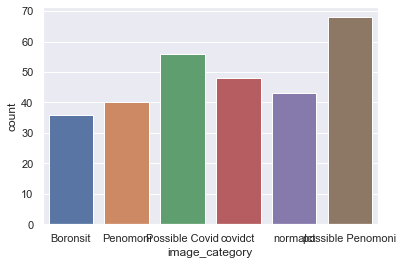

In [160]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="image_category", data=dataset_df)

In [161]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 15

In [162]:
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

In [163]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


In [164]:
labels.shape


(291,)

In [165]:
labels[5]

'DataSet/seg_train/Boronsit'

In [166]:
print(labels)

['DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsit'
 'DataSet/seg_train/Boronsit' 'DataSet/seg_train/Boronsi

In [167]:
labels[1]

'DataSet/seg_train/Boronsit'

In [168]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
num_labels=le.fit_transform(labels)
cat_labels=le.inverse_transform(num_labels)

In [169]:
num_labels.shape

(291,)

In [170]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder=OneHotEncoder(sparse=False)
num_labels=num_labels.reshape(len(num_labels),1)
onehot_encoded=onehot_encoder.fit_transform(num_labels)

In [171]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
#labels = lb.fit_transform(labels [:,None])
labels = to_categorical(num_labels )

In [172]:


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, onehot_encoded,test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

## Build the model

In [173]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [174]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])



[INFO] compiling model...


In [175]:
#from sklearn.preprocessing import OneHotEncoder
#onehot_encoder=OneHotEncoder(sparse=False)
#num_labels=num_labels.reshape(len(num_labels),1)
#onehot_encoded=onehot_encoder.fit_transform(num_labels)

## Training the model

In [176]:
# train the head of the network
print("[INFO] training head...")
EPOCHS = 3
BS = 5
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/3
46/46 [==============================] - 332s 7s/step - loss: 0.4806 - acc: 0.8297 - val_loss: 0.4526 - val_acc: 0.8333
Epoch 2/3
46/46 [==============================] - 327s 7s/step - loss: 0.4518 - acc: 0.8333 - val_loss: 0.4524 - val_acc: 0.8333
Epoch 3/3
46/46 [==============================] - 328s 7s/step - loss: 0.4500 - acc: 0.8333 - val_loss: 0.4518 - val_acc: 0.8333


In [177]:
import seaborn as sns
predicted_metrics = model.evaluate(testX, testY,batch_size=BS, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

#plot_cm(trueIdxs, predIdxs)
#plt.savefig('confusion_matrix.pdf', format='pdf')

loss :  0.45169325400207
acc :  0.8333334



## Test the model

In [178]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

#target_names=lb.inverse_transform

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         9
           5       0.24      1.00      0.38        14

    accuracy                           0.24        59
   macro avg       0.04      0.17      0.06        59
weighted avg       0.06      0.24      0.09        59



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [179]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 0  0  0  0  0  7]
 [ 0  0  0  0  0  8]
 [ 0  0  0  0  0 11]
 [ 0  0  0  0  0 10]
 [ 0  0  0  0  0  9]
 [ 0  0  0  0  0 14]]
acc: 0.0000
sensitivity: nan
specificity: nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


In [180]:
def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''
    print(classification_report(labels, predictions))
    #target_names=lb.classes_
    cm = confusion_matrix(labels, predictions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("accuracy: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    print()
    print('Correct Healthy Patient Detection (True Negatives): ', cm[0][0])
    print('Incorrect Covid-19 Detection (False Positives): ', cm[0][1])
    print('Incorrect Healthy Patient Detection (False Negatives): ', cm[1][0])
    print('Correct Covid-19 Detection (True Positives): ', cm[1][1])
    print('Total Patietns with Covid-19: ', np.sum(cm[1]))

    print()
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [181]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
print('\nNumber of test scans: ', len(testX))
print('Predicted class probabilities:')
print(predIdxs)

    
# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Boronsit=0, Penomoni=1 , Possible Covid=2,covidct=3 ,normalct=4 ,possible Penomoni=5):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)



[INFO] evaluating network...

Number of test scans:  59
Predicted class probabilities:
[[0.16447559 0.14197606 0.16712062 0.1568792  0.14264657 0.2269019 ]
 [0.16303565 0.13390024 0.17125186 0.1638564  0.15262514 0.2153307 ]
 [0.14856614 0.11543064 0.1671311  0.17352894 0.15243952 0.24290355]
 [0.16424339 0.1510551  0.15663992 0.15807053 0.15590036 0.21409063]
 [0.15776263 0.16050345 0.1774065  0.16899873 0.13298191 0.20234679]
 [0.16965638 0.15577722 0.18130799 0.14684688 0.1310663  0.21534528]
 [0.15045963 0.13404073 0.17963368 0.16799161 0.14435989 0.2235144 ]
 [0.15298672 0.12307477 0.1588675  0.17714939 0.15460387 0.23331782]
 [0.15007278 0.16319196 0.19010012 0.15707004 0.13041915 0.20914595]
 [0.15441443 0.12597522 0.15558046 0.16043815 0.14242189 0.26116988]
 [0.14948384 0.15892057 0.1897019  0.15839298 0.1283802  0.21512058]
 [0.16753745 0.14352952 0.18777649 0.17051914 0.12186494 0.20877242]
 [0.14948384 0.15892057 0.1897019  0.15839298 0.1283802  0.21512058]
 [0.16137387 0.1

loss :  0.45169325400207
acc :  0.8333334

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         9
           5       0.24      1.00      0.38        14

    accuracy                           0.24        59
   macro avg       0.04      0.17      0.06        59
weighted avg       0.06      0.24      0.09        59

accuracy: 0.0000
sensitivity: nan
specificity: nan

Correct Healthy Patient Detection (True Negatives):  0
Incorrect Covid-19 Detection (False Positives):  0
Incorrect Healthy Patient Detection (False Negatives):  0
Correct Covid-19 Detection (True Positives):  0
Total Patietns with Covid-19:  8



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_la

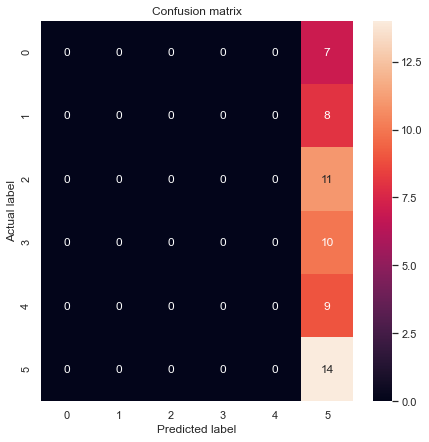

In [182]:
import seaborn as sns
predicted_metrics = model.evaluate(testX, testY,batch_size=BS, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)
#plt.savefig('confusion_matrix.pdf', format='pdf')

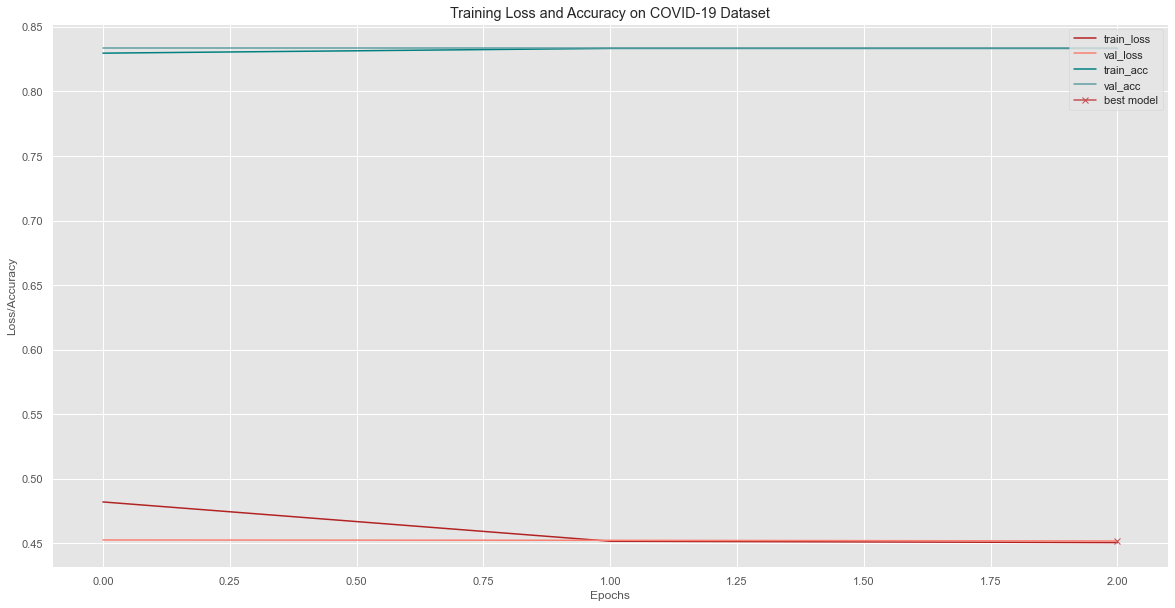

In [183]:
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()

In [184]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 0  0  0  0  0  7]
 [ 0  0  0  0  0  8]
 [ 0  0  0  0  0 11]
 [ 0  0  0  0  0 10]
 [ 0  0  0  0  0  9]
 [ 0  0  0  0  0 14]]
acc: 0.0000
sensitivity: nan
specificity: nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


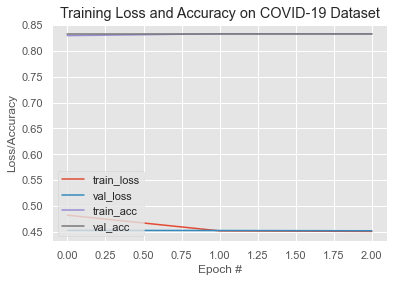

<Figure size 432x288 with 0 Axes>

In [185]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot.png")

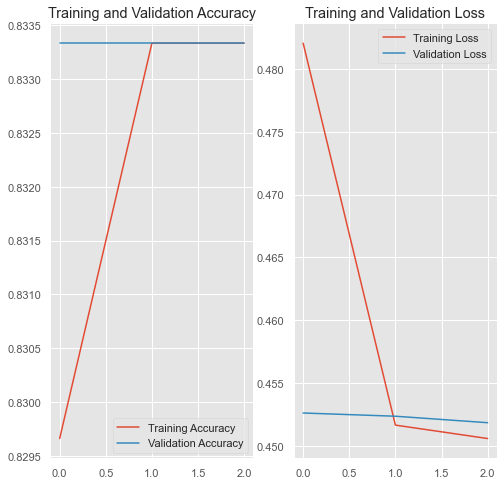

In [186]:
from keras.callbacks import ModelCheckpoint,History,EarlyStopping,LearningRateScheduler
acc = H.history['acc']
val_acc = H.history['val_acc']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [187]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(model_name, save_format="h5")
model.save('FullModelDetect_Kovid_Ardabil.h5')
print("Saved Model : FullModelDetect_Kovid_Ardabil in Folder Successfuly")


[INFO] saving COVID-19 detector model...
Saved Model : FullModelDetect_Kovid_Ardabil in Folder Successfuly


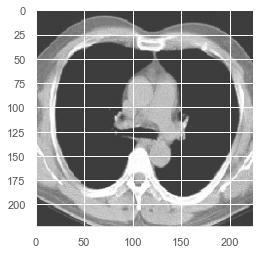

acc : = [0.8296625, 0.8333335, 0.8333335]
Prediction : = Penomoni
Actual : = Penomoni


In [201]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import load_model
import matplotlib.pyplot as plt

#model=load_model("/content/drive/My Drive/covid19-dataset/covid191.h5")
_img=load_img("1%0.jpg",target_size=(224,224))
img=img_to_array(_img)
img=np.expand_dims(img,axis=0)
img=preprocess_input(img)
#plt.subplot(1,2,1)
plt.imshow(_img)
#plt.subplot(1,2,2)
#plt.imshow(img)
plt.show()
features=model.predict(img)

print('acc : =' ,acc )
print('Prediction : =' ,prediction )
print('Actual : =' ,prediction )
#for GradCAM
class_idxs_sorted = np.argsort(features.flatten())[::-1]

{'Boronsit': 0, 'Penomoni': 1, 'Possible Covid': 2, 'covidct': 3, 'normalct': 4, 'possible Penomoni': 5}
0.5741556
acc : = [0.8296625, 0.8333335, 0.8333335]
Prediction : = normalct
Actual : = normalct


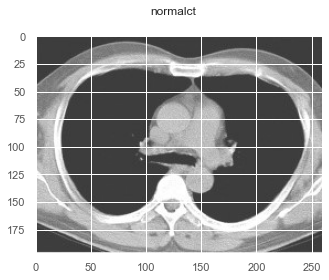

In [204]:
import cv2
import matplotlib.image as mpimg
img_src = '1%0.jpg'
img = cv2.imread(img_src)
img_pred = load_img('1%0.jpg', target_size = (224, 224))
img_pred = img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)
ind = train_image_gen.class_indices
print(ind)


#train_image_gen.class_indices
classnumber=np.argmax(rslt[0])
classnames=["Boronsit","Penomoni","Possible Covid","covidct","normalct","possible Penomoni"]
prediction=classnames[np.argmax(rslt[0]*100)]
#prediction=('%.2f' % (probability[1]*100)
score=rslt[0][classnumber]
print(score)

target_width = 50
target_height = 50
target_size = (target_width, target_height)
img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)
fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)
np_img = mpimg.imread(img_src)
plt.imshow(np_img)
print('acc : =' ,acc )
print('Prediction : =' ,prediction )
print('Actual : =' ,prediction )






intensity =  0.5741556
acc : = [0.8296625, 0.8333335, 0.8333335]
Prediction : = normalct
Actual : = normalct
Comment =


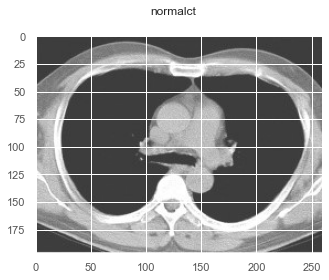

In [206]:
import cv2
import matplotlib.image as mpimg
img_src = '1%0.jpg'
img = cv2.imread(img_src)
img_pred = load_img('1%0.jpg', target_size = (224, 224))
img_pred = img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)
ind = train_image_gen.class_indices
#print(ind)


#train_image_gen.class_indices
classnumber=np.argmax(rslt[0])
classnames=["Boronsit","Penomoni","Possible Covid","covidct","normalct","possible Penomoni"]
prediction=classnames[np.argmax(rslt[0]*100)]
#prediction=('%.2f' % (probability[1]*100)
score=rslt[0][classnumber]


#if prediction[0]:
#    print("this is a Dog")
#if prediction[1]:
#    print("this is a Cat")




print( )
print( )
print( )
print( )
print( )
print("intensity = ",score)
target_width = 50
target_height = 50
target_size = (target_width, target_height)
img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)
fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)
np_img = mpimg.imread(img_src)
plt.imshow(np_img)
print('acc : =' ,acc )
print('Prediction : =' ,prediction )
print('Actual : =' ,prediction )
print( "Comment =" )

In [195]:
def smooth_curve(points, factor=0.8):
  """
  Helper function to help smooth accuracy/loss plots using an exponential
  moving average of the loss and accuracy values. 
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def get_plots(history, smooth=False):
  """
  Helper function to plot training/validation accuracy/loss.
  @param history - Keras model history 
  @param smooth - Boolean for whether to smooth plots or not
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  
  if smooth == True:
    acc = smooth_curve(acc)
    val_acc = smooth_curve(val_acc)
    loss = smooth_curve(loss)
    val_loss = smooth_curve(val_loss)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc,'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def get_metrics(model, generator, steps, target_names=[]):
  """
  Function to print out confusion matrix and classification report.
  """
  target_names = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
  abbreviations = ['BM', 'BR', 'LB', 'H']
  
  # Get predictions for data
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Get confusion matix
  cnf_mat = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
  ax.set_xticklabels(abbreviations)
  ax.set_yticklabels(abbreviations)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.show()
  
  # Get classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=target_names))

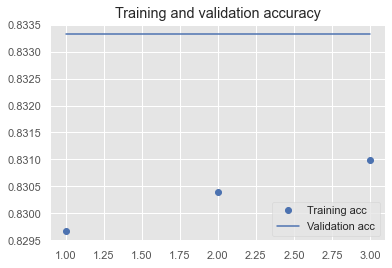

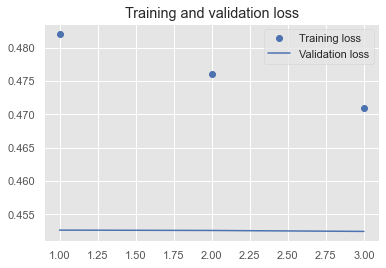

In [196]:
get_plots(H, smooth=True)

NameError: name 'Compose' is not defined

In [209]:
# Random Colour Mask Generator for Images 
def colour_masks(image):
  colours = []
  colours_names = ['cyan', 'coral', 'limegreen', 'chartreuse', 'aqua', 'magenta', 'orange', 'yellow', 'deeppink', 'darkviolet']
  for color in colours_names:
    cl = Color(color)
    rgb = [round(val*255, 0) for val in cl.rgb]
    colours.append(rgb)
  red = np.zeros_like(image).astype(np.uint8)
  green = np.zeros_like(image).astype(np.uint8)
  blue = np.zeros_like(image).astype(np.uint8)
  red[image == 1], green[image == 1], blue[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([red, green, blue], axis=2)
  return coloured_mask

In [210]:
COCO_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus']

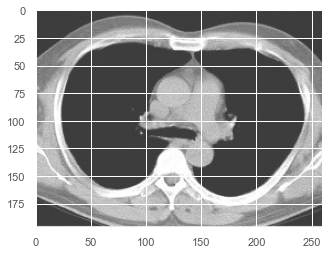

In [217]:
# visualizing the original image
import matplotlib.image as pltimg
img=pltimg.imread('1%0.jpg')
plt.imshow(img)
plt.show()

In [222]:
def predict(img_path, threshold):
  img = Image.reload(img_path)
  with torch.no_grad():
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])

    # scores of predicted classes
    pred_scores = list(pred[0]['scores'].numpy())
    pred_score = [x for x in pred_scores if x>threshold]

    # number of predictions with score above threshold value
    num_pred = len(pred_score)

    # coordinates of predicted bounding box
    pred_boxes = [[(vrtx[0], vrtx[1]), (vrtx[2], vrtx[3])] for vrtx in list(pred[0]['boxes'].numpy())]

    # predicted masks above threshold
    pred_masks = (pred[0]['masks']>threshold).squeeze().numpy()

    # predicted class names
    pred_class = [COCO_CATEGORY_NAMES[indx] for indx in list(pred[0]['labels'].numpy())]

    masks = pred_masks[:num_pred]
    pred_boxes = pred_boxes[:num_pred]
    pred_class = pred_class[:num_pred]
  return masks, pred_boxes, pred_class, pred_score

In [223]:
def instance_segmentation_runner(img_path, threshold=0.5, rect=3, font_size=2, text=2):
  masks, boxes, pred_cls, pred_score = predict(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # creating colored masks of every predicted mask
  for i in range(len(masks)):
    rgb_mask = colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    # draw bounding box with the predicted coordinates 
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect)
    # add predicted label with score as text 
    cv2.putText(img,pred_cls[i]+' '+str(round(pred_score[i],2)), boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, font_size, (0,0,255),thickness=text)
  plt.figure(figsize=(10,20))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [226]:
#instance_segmentation_runner('1%0.jpg')